In [1]:
import pandas as pd
from pathlib import Path
import plotly.express as px

import numpy as np

In [2]:
DATA_DIR = Path("../data/processed")
premium_df = pd.read_csv(DATA_DIR / "lang_pop2022adj_costs.csv")

augmented_premium_df = premium_df.merge(
    premium_df.groupby("lang")[["population_2022adj", "NY.GDP.PCAP.CD"]].apply(
        lambda df: (df["population_2022adj"] * df["NY.GDP.PCAP.CD"]).sum() / df["population_2022adj"].sum(),
        include_groups=False
    ).rename("pop_weighted_wealth"),
    how="left",
    left_on="lang",
    right_index=True
).merge(
    premium_df.groupby("lang")["population_2022adj"].sum().rename("total_population"),
    how="left",
    left_on="lang",
    right_index=True
)

# https://blogs.worldbank.org/en/opendata/new-world-bank-group-country-classifications-income-level-fy24
augmented_premium_df["weighted_wealth_income_classification"] = pd.cut(
        augmented_premium_df["pop_weighted_wealth"],
        bins=[0, 1135, 4465, 13845, np.inf],
        labels=["Low income", "Lower middle income", "Upper middle income", "High income"]
    )

augmented_premium_df.head()

,lang,location,country,year,population,population_2022adj,NY.GDP.PCAP.CD,id,incomeLevel,cl100k_base,o200k_base,pop_weighted_wealth,total_population,weighted_wealth_income_classification
0,ace,Indonesia,IDN,2010.0,2840000.0,3244518.0,4787.999308,IDN,Upper middle income,2.910664,2.235000,4787.999308,3244518.0,Upper middle income
1,acm,United Arab Emirates,ARE,2020.0,38000.0,38943.0,53707.980081,ARE,High income,3.000731,1.389443,7543.131613,18606581.0,Upper middle income
2,acm,Australia,AUS,2021.0,83300.0,84451.0,65099.845912,AUS,High income,3.000731,1.389443,7543.131613,18606581.0,Upper middle income
3,acm,Belgium,BEL,2020.0,8140.0,8279.0,49926.825430,BEL,High income,3.000731,1.389443,7543.131613,18606581.0,Upper middle income
4,acm,Canada,CAN,2021.0,63500.0,65030.0,55522.445688,CAN,High income,3.000731,1.389443,7543.131613,18606581.0,Upper middle income


In [3]:
income_tokenizer_trend = (augmented_premium_df
    .drop_duplicates(subset=["lang"])
    .groupby(
        ["weighted_wealth_income_classification"],
        observed=True)[["cl100k_base", "o200k_base"]]
    .mean())

income_tokenizer_trend

,cl100k_base,o200k_base
weighted_wealth_income_classification,,
Low income,3.353315,2.712796
Lower middle income,4.590917,2.436008
Upper middle income,3.520217,2.170148
High income,2.233746,1.642925


In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplots with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

name_map = {
    "cl100k_base": "GPT-4 (cl100k_base)",
    "o200k_base": "GPT-4o (o200k_base)"
}

# Add lines for each income classification
for income_class, row in income_tokenizer_trend.iterrows():
    # Add trace for cl100k_base (left y-axis)
    fig.add_trace(go.Scatter(
        x=['GPT-4 (cl100k_base)', 'GPT-4o (o200k_base)'],
        y=[income_tokenizer_trend.loc[income_class, 'cl100k_base'], income_tokenizer_trend.loc[income_class, 'o200k_base']],
        mode='lines+markers',
        name=income_class
    ), secondary_y=False)

# Update layout
fig.update_layout(
    title=dict(
        text="Tokenization Premium Trend of Languages by Weighted Wealth<br>Income Classification (GPT-4 vs. GPT-4o Tokenizers)",
        font=dict(size=15),
    ),
    xaxis=dict(tickvals=[0, 1], ticktext=['GPT-4 (cl100k_base)', 'GPT-4o (o200k_base)']),
    legend_title="Income Classification",
    # font=dict(size=12),
    plot_bgcolor='white',
    width=600,
    height=600,
    legend=dict(
        orientation="v",  # Keep the legend vertical
        x=0.75,  # Move it inside the plot area on the right
        y=0.95,
        xanchor="center",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.5)"  # Optional: add a semi-transparent background to the legend
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    autosize=True,
)

# Set x-axis title and y-axes titles
fig.update_xaxes(title_text="Tokenizer")
fig.update_yaxes(title_text="Tokenization Premium", secondary_y=False)
fig.update_yaxes(title_text="o200k_base", secondary_y=True)

fig.write_image("../reports/tokenization-premium-trend.png", format="png", scale=4)

# Show plot
fig.show()


In [5]:
# Measure population impacted by tokenization premium
augmented_premium_df["group_cl100k_base"] = pd.cut(augmented_premium_df["cl100k_base"], bins=[0, 1, 2, 4, 6, 8, 10, 16])
augmented_premium_df["group_o200k_base"] = pd.cut(augmented_premium_df["o200k_base"], bins=[0, 1, 2, 4, 6, 8, 10, 16])

income_pop_gpt4 = augmented_premium_df.groupby(["incomeLevel", "group_cl100k_base"], observed=False)["population"].sum().unstack().fillna(0).astype(int).copy()
income_pop_gpt4_frac = (income_pop_gpt4.cumsum(axis=1) / income_pop_gpt4.sum(axis=1).values[:, None])
income_pop_gpt4_frac = income_pop_gpt4_frac.loc[["High income", "Upper middle income", "Lower middle income", "Low income"]]

income_pop_gpt4o = augmented_premium_df.groupby(["incomeLevel", "group_o200k_base"], observed=False)["population"].sum().unstack().fillna(0).astype(int).copy()
income_pop_gpt4o_frac = (income_pop_gpt4o.cumsum(axis=1) / income_pop_gpt4o.sum(axis=1).values[:, None])
income_pop_gpt4o_frac = income_pop_gpt4o_frac.loc[["High income", "Upper middle income", "Lower middle income", "Low income"]]

income_pop_gpt4_frac

group_cl100k_base,"(0, 1]","(1, 2]","(2, 4]","(4, 6]","(6, 8]","(8, 10]","(10, 16]"
incomeLevel,,,,,,,
High income,0.388935,0.764044,0.977118,0.993928,0.997474,0.999789,1.0
Upper middle income,0.038856,0.356908,0.965131,0.996041,0.996772,0.999336,1.0
Lower middle income,0.175086,0.253024,0.503445,0.863727,0.914887,0.974523,1.0
Low income,0.063463,0.308522,0.877701,0.885125,1.000000,1.000000,1.0


In [6]:
pd.concat([pd.DataFrame([0] * income_pop_gpt4_frac.shape[0], index=income_pop_gpt4_frac.index), income_pop_gpt4_frac], axis=1).diff(axis=1).iloc[:, 1:]

,"(0, 1]","(1, 2]","(2, 4]","(4, 6]","(6, 8]","(8, 10]","(10, 16]"
incomeLevel,,,,,,,
High income,0.388935,0.375109,0.213074,0.016810,0.003547,0.002314,0.000211
Upper middle income,0.038856,0.318052,0.608223,0.030911,0.000730,0.002564,0.000664
Lower middle income,0.175086,0.077939,0.250420,0.360283,0.051160,0.059636,0.025477
Low income,0.063463,0.245058,0.569179,0.007424,0.114875,0.000000,0.000000


In [7]:
income_pop_gpt4o_frac

group_o200k_base,"(0, 1]","(1, 2]","(2, 4]","(4, 6]","(6, 8]","(8, 10]","(10, 16]"
incomeLevel,,,,,,,
High income,0.388935,0.987281,0.999210,0.999573,0.999797,0.999912,1.0
Upper middle income,0.038856,0.984464,0.999593,0.999600,0.999602,1.000000,1.0
Lower middle income,0.175086,0.903688,0.984374,0.994783,0.994820,0.997242,1.0
Low income,0.063463,0.830792,0.886327,0.983203,1.000000,1.000000,1.0


In [8]:
pd.concat([pd.DataFrame([0] * income_pop_gpt4o_frac.shape[0], index=income_pop_gpt4o_frac.index), income_pop_gpt4o_frac], axis=1).diff(axis=1).iloc[:, 1:]

,"(0, 1]","(1, 2]","(2, 4]","(4, 6]","(6, 8]","(8, 10]","(10, 16]"
incomeLevel,,,,,,,
High income,0.388935,0.598346,0.011928,0.000363,0.000224,0.000116,0.000088
Upper middle income,0.038856,0.945608,0.015129,0.000007,0.000002,0.000398,0.000000
Lower middle income,0.175086,0.728602,0.080686,0.010410,0.000037,0.002422,0.002758
Low income,0.063463,0.767328,0.055535,0.096877,0.016797,0.000000,0.000000


In [9]:
income_pop_gpt4.cumsum(axis=1)

group_cl100k_base,"(0, 1]","(1, 2]","(2, 4]","(4, 6]","(6, 8]","(8, 10]","(10, 16]"
incomeLevel,,,,,,,
High income,687097240,1349768930,1726186810,1755883277,1762148777,1766237007,1766610477
Low income,38641370,187851620,534411530,538931850,608876650,608876650,608876650
Lower middle income,669383480,967355910,1924755220,3302176992,3497770452,3725767652,3823171052
Not classified,29400,29619200,29760300,29766400,29766400,29766400,29766400
Upper middle income,119873340,1101078080,2977475006,3072835426,3075088526,3082998828,3085047828


## Shortlist languages

- Top 3 languages with the highest premium from low-income countries.
  - dzo="Dzongkha"
  - taq="Tamasheq"
  - kbp="Kabiyè"
- Top 3 languages with the highest premium from low-middle-income countries.
  - shn="Shan"
  - sat="Santhali"
  - ory="Odia"
- Top 3 languages by total population with at least 4x premium from low-income countries.
  - nus="Nuer"
  - kbp="Kabiyè"
  - taq="Tamasheq"
- Top 3 languages by total population with at least 4x premium from low-middle-income countries.
  - hin="Hindi"
  - ben="Bengali"
  - urd="Urdu"
- Top 5 languages by total population.
  - eng="English"
  - zho="Chinese"
  - hin="Hindi"
  - spa="Spanish"
  - arb="Standard Arabic"
  - fra="French"

In [49]:
augmented_premium_df.loc[augmented_premium_df.isnull().sum(axis=1) > 0] #.dropna(subset=["pop_weighted_wealth"])

,lang,location,country,year,population,population_2022adj,NY.GDP.PCAP.CD,id,incomeLevel,cl100k_base,o200k_base,pop_weighted_wealth,total_population,weighted_wealth_income_classification,group_cl100k_base,group_o200k_base
17,acm,Lebanon,LBN,2022.0,1.840000e+04,1.840000e+04,NaN,LBN,Lower middle income,3.000731,1.389443,7543.131613,1.860658e+07,Upper middle income,"(2, 4]","(1, 2]"
22,acm,Syria,SYR,2023.0,6.770000e+04,6.770000e+04,NaN,SYR,Low income,3.000731,1.389443,7543.131613,1.860658e+07,Upper middle income,"(2, 4]","(1, 2]"
29,acq,Eritrea,ERI,2024.0,3.800000e+04,3.800000e+04,NaN,ERI,Low income,3.031674,1.401661,2595.523605,1.269337e+07,Lower middle income,"(2, 4]","(1, 2]"
115,amh,South Sudan,SSD,2020.0,1.300000e+04,1.357500e+04,NaN,SSD,Low income,7.705929,5.853588,1617.088937,6.439829e+07,Lower middle income,"(6, 8]","(4, 6]"
133,apc,Cuba,CUB,2023.0,2.000000e+04,2.000000e+04,NaN,CUB,Upper middle income,2.844917,1.356936,9641.391421,5.408853e+07,Upper middle income,"(2, 4]","(1, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,urd,"Afghanistan, all users. L1 users: 16,900 in Af...",AFG,2020.0,1.146900e+06,1.247414e+06,NaN,AFG,Low income,4.401929,1.667588,2433.621694,2.645303e+08,Lower middle income,"(4, 6]","(1, 2]"
2945,vie,China–Taiwan,TWN,2018.0,1.940000e+05,8.753000e+03,NaN,NaN,NaN,2.477658,1.504384,6119.101033,8.897282e+07,Upper middle income,"(2, 4]","(1, 2]"
3009,yue,Guam,GUM,2022.0,1.200000e+03,1.200000e+03,NaN,GUM,High income,2.111599,1.390468,17247.901211,8.670095e+07,High income,"(2, 4]","(1, 2]"
3027,yue,Réunion,REU,2021.0,1.440000e+04,1.694000e+03,NaN,NaN,NaN,2.111599,1.390468,17247.901211,8.670095e+07,High income,"(2, 4]","(1, 2]"


In [4]:
# Top 3 languages with the highest premium from low-income countries.
augmented_premium_df[
    # (augmented_premium_df["cl100k_base"] > 4) &
    (augmented_premium_df["weighted_wealth_income_classification"]  == "Low income")].drop_duplicates("lang").sort_values("cl100k_base", ascending=False).head(3)

,lang,location,country,year,population,population_2022adj,NY.GDP.PCAP.CD,id,incomeLevel,cl100k_base,o200k_base,pop_weighted_wealth,total_population,weighted_wealth_income_classification
709,dzo,Bhutan,BTN,2021.0,304000.0,307903.0,NaN,BTN,Lower middle income,12.459297,9.222634,100.044211,321275.0,Low income
2562,taq,Burkina Faso,BFA,2021.0,187000.0,196870.0,830.037150,BFA,Low income,6.283203,6.261983,1010.426489,919624.0,Low income
1504,kbp,Benin,BEN,2021.0,17200.0,18152.0,1302.851036,BEN,Lower middle income,4.799921,3.974989,947.709170,1292355.0,Low income


In [5]:
# Top 3 languages with the highest premium from low-middle-income countries.
augmented_premium_df[
    # (augmented_premium_df["cl100k_base"] > 4) &
    (augmented_premium_df["weighted_wealth_income_classification"]  == "Lower middle income")].drop_duplicates("lang").sort_values("cl100k_base", ascending=False).head(3)

,lang,location,country,year,population,population_2022adj,NY.GDP.PCAP.CD,id,incomeLevel,cl100k_base,o200k_base,pop_weighted_wealth,total_population,weighted_wealth_income_classification
2236,shn,Myanmar,MMR,2017.0,4590000.0,4791547.0,1149.211218,MMR,Lower middle income,15.328765,8.103200,1270.962393,4895001.0,Lower middle income
2231,sat,Bangladesh,BGD,2011.0,225000.0,259344.0,2688.305501,BGD,Lower middle income,12.962892,13.926960,2410.680911,8699573.0,Lower middle income
1909,ory,Bangladesh,BGD,2000.0,32500.0,43803.0,2688.305501,BGD,Lower middle income,12.594206,5.049518,2416.803702,45378324.0,Lower middle income


In [6]:
# Top 3 languages by total population with at least 4x premium from low-income countries.
augmented_premium_df[
    (augmented_premium_df["cl100k_base"] >= 4) &
    (augmented_premium_df["weighted_wealth_income_classification"]  == "Low income")].sort_values("total_population", ascending=False).drop_duplicates("lang").head(3)

,lang,location,country,year,population,population_2022adj,NY.GDP.PCAP.CD,id,incomeLevel,cl100k_base,o200k_base,pop_weighted_wealth,total_population,weighted_wealth_income_classification
1898,nus,"Ethiopia, all users. L1 users: 153,000 in Ethi...",ETH,2007.0,154120.0,237216.0,1027.585911,ETH,Low income,4.031437,3.268707,138.208952,1763705.0,Low income
1504,kbp,Benin,BEN,2021.0,17200.0,18152.0,1302.851036,BEN,Lower middle income,4.799921,3.974989,947.709170,1292355.0,Low income
2562,taq,Burkina Faso,BFA,2021.0,187000.0,196870.0,830.037150,BFA,Low income,6.283203,6.261983,1010.426489,919624.0,Low income


In [7]:
# Top 3 languages by total population with at least 4x premium from low-middle-income countries.
augmented_premium_df[
    (augmented_premium_df["cl100k_base"] >= 4) &
    (augmented_premium_df["weighted_wealth_income_classification"]  == "Lower middle income")].sort_values("total_population", ascending=False).drop_duplicates("lang").head(3)

,lang,location,country,year,population,population_2022adj,NY.GDP.PCAP.CD,id,incomeLevel,cl100k_base,o200k_base,pop_weighted_wealth,total_population,weighted_wealth_income_classification
1224,hin,Luxembourg,LUX,2021.0,1300.0,1346.0,125006.021815,LUX,High income,4.821501,1.587333,2767.026060,694180807.0,Lower middle income
357,ben,Belgium,BEL,2018.0,5000.0,5136.0,49926.825430,BEL,High income,5.877417,1.710945,3321.487299,297023859.0,Lower middle income
2863,urd,Canada,CAN,2021.0,415000.0,424999.0,55522.445688,CAN,High income,4.401929,1.667588,2433.621694,264530341.0,Lower middle income


In [8]:
# Top 5 languages by total population.
augmented_premium_df.dropna(subset=["cl100k_base"]).sort_values(["total_population", "population"], ascending=False).drop_duplicates("lang").head(6)

,lang,location,country,year,population,population_2022adj,NY.GDP.PCAP.CD,id,incomeLevel,cl100k_base,o200k_base,pop_weighted_wealth,total_population,weighted_wealth_income_classification
939,eng,"United States, all users. L1 users: 257,000,00...",USA,2019.0,3.060000e+08,3.120179e+08,76329.582265,USA,High income,1.000000,1.000000,22794.976819,1.974081e+09,High income
3036,zho,China,CHN,NaN,1.352665e+09,1.352665e+09,12720.216318,CHN,Upper middle income,2.019078,1.339837,12720.216318,1.352665e+09,Upper middle income
1214,hin,"India, all users. L1 users: 339,000,000 in India",IND,2011.0,6.020000e+08,6.871545e+08,2410.888021,IND,Lower middle income,4.821501,1.587333,2767.026060,6.941808e+08,Lower middle income
2415,spa,"Mexico, all users. L1 users: 122,000,000 in Me...",MEX,2021.0,1.302400e+08,1.317919e+08,11496.522872,MEX,Upper middle income,1.565468,1.330588,18333.500383,5.844301e+08,High income
205,arb,Egypt,EGY,2023.0,7.720000e+07,7.720000e+07,4295.407496,EGY,Lower middle income,2.764246,1.832455,7706.676159,3.324590e+08,Upper middle income
1020,fra,"France, all users. L1 users: 55,600,000 in France",FRA,2020.0,6.570000e+07,6.626788e+07,40886.253268,FRA,High income,1.620679,1.379368,22726.073460,3.215457e+08,High income


In [9]:
## Shortlist languages  # Check the analysis.ipynb notebook for the details
lang_shortlist = [
    # - Top 3 languages with the highest premium from low-income countries.
    dict(
        dzo=dict(
            name="Dzongkha",
            code="dzo_Tibt",
        ),
        taq=dict(
            name="Tamasheq",
            code="taq_Latn",
        ),
        kbp=dict(
            name="Kabiyè",
            code="kbp_Latn",
        ),
    ),
    # - Top 3 languages with the highest premium from low-middle-income countries.
    dict(
        shn=dict(
            name="Shan",
            code="shn_Mymr",
        ),
        sat=dict(
            name="Santhali",
            code="sat_Olck",
        ),
        ory=dict(
            name="Odia",
            code="ory_Orya",
        ),
    ),
    # - Top 3 languages by total population with at least 4x premium from low-income countries.
    dict(
    nus=dict(
        name="Nuer",
        code="nus_Latn",
    ),
    kbp=dict(
        name="Kabiyè",
        code="kbp_Latn",
    ),
    taq=dict(
        name="Tamasheq",
        code="taq_Latn",
    ),
    ),
    # - Top 3 languages by total population with at least 4x premium from low-middle-income countries.
    dict(
        hin=dict(
            name="Hindi",
            code="hin_Deva",
        ),
        ben=dict(
            name="Bengali",
            code="ben_Beng",
        ),
        urd=dict(
            name="Urdu",
            code="urd_Arab",
        ),
    ),
    # - Top 5 languages by total population.
    dict(
        eng=dict(
            name="English",
            code="eng_Latn",
        ),
        zho=dict(
            name="Chinese",
            code="zho_Hans",
        ),
        hin=dict(
            name="Hindi",
            code="hin_Deva",
        ),
        spa=dict(
            name="Spanish",
            code="spa_Latn",
        ),
        arb=dict(
            name="Standard Arabic",
            code="arb_Arab",
        ),
        fra=dict(
            name="French",
            code="fra_Latn",
        ),
    ),
]

lang_name = {k: v for d in lang_shortlist for k, v in d.items()}
lang_name

{'dzo': {'name': 'Dzongkha', 'code': 'dzo_Tibt'},
 'taq': {'name': 'Tamasheq', 'code': 'taq_Latn'},
 'kbp': {'name': 'Kabiyè', 'code': 'kbp_Latn'},
 'shn': {'name': 'Shan', 'code': 'shn_Mymr'},
 'sat': {'name': 'Santhali', 'code': 'sat_Olck'},
 'ory': {'name': 'Odia', 'code': 'ory_Orya'},
 'nus': {'name': 'Nuer', 'code': 'nus_Latn'},
 'hin': {'name': 'Hindi', 'code': 'hin_Deva'},
 'ben': {'name': 'Bengali', 'code': 'ben_Beng'},
 'urd': {'name': 'Urdu', 'code': 'urd_Arab'},
 'eng': {'name': 'English', 'code': 'eng_Latn'},
 'zho': {'name': 'Chinese', 'code': 'zho_Hans'},
 'spa': {'name': 'Spanish', 'code': 'spa_Latn'},
 'arb': {'name': 'Standard Arabic', 'code': 'arb_Arab'},
 'fra': {'name': 'French', 'code': 'fra_Latn'}}

In [10]:
ordered_langs = augmented_premium_df[
    augmented_premium_df["lang"].isin(lang_name.keys())
].sort_values(["weighted_wealth_income_classification", "total_population"], ascending=[True, False]).drop_duplicates("lang")["lang"].tolist()
print(ordered_langs)

['nus', 'kbp', 'taq', 'dzo', 'hin', 'ben', 'urd', 'ory', 'sat', 'shn', 'zho', 'arb', 'eng', 'spa', 'fra']


In [11]:
augmented_premium_df["weighted_wealth_income_classification"].unique()

['Upper middle income', 'Lower middle income', 'High income', 'Low income', NaN]
Categories (4, object): ['Low income' < 'Lower middle income' < 'Upper middle income' < 'High income']

# Measure average decrease in tokenization premium between models

<Axes: >

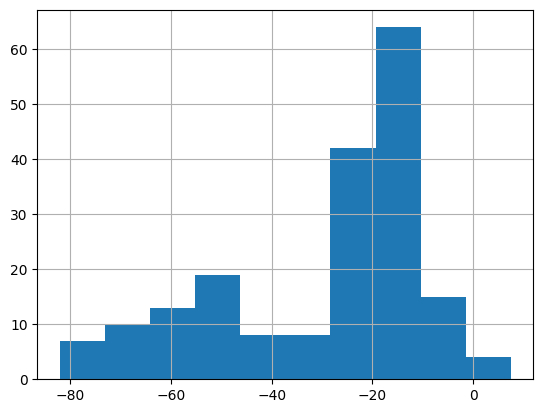

In [12]:
ulang_df = augmented_premium_df.drop_duplicates(subset=["lang"]).copy()


ulang_df["premium_diff"] = ulang_df["o200k_base"] - ulang_df["cl100k_base"]
ulang_df["premium_diff_pct"] = 100 * ulang_df["premium_diff"] / ulang_df["cl100k_base"]

ulang_df["premium_diff_pct"].hist(bins=10)

In [13]:
fig = px.histogram(ulang_df, x="premium_diff_pct", nbins=10, text_auto=True)

fig.update_layout(
    plot_bgcolor='white',
    title_text='Change in tokenization premium from GPT-4 to GPT-4o', # title of plot
    xaxis_title_text='Premium delta (%)', # xaxis label
    yaxis_title_text='# of languages', # yaxis label
    bargap=0.01, # gap between bars of adjacent location coordinates
)
fig.write_image("../reports/premium_change.png", format="png", scale=4)
fig.show()

In [14]:
ulang_df.sort_values("premium_diff_pct", ascending=False, inplace=True)
ulang_df

,lang,location,country,year,population,population_2022adj,NY.GDP.PCAP.CD,id,incomeLevel,cl100k_base,o200k_base,pop_weighted_wealth,total_population,weighted_wealth_income_classification,premium_diff,premium_diff_pct
2231,sat,Bangladesh,BGD,2011.0,225000.0,259344.0,2688.305501,BGD,Lower middle income,12.962892,13.926960,2410.680911,8.699573e+06,Lower middle income,0.964067,7.437132
2789,tzm,Canada,CAN,2021.0,4740.0,4854.0,55522.445688,CAN,High income,10.150779,10.258220,5538.420928,3.188939e+06,Upper middle income,0.107441,1.058451
773,eng,"Aruba, all users. L1 users: 7,880 in Aruba",ABW,2020.0,63480.0,63482.0,33300.838819,ABW,High income,1.000000,1.000000,22794.976819,1.974081e+09,High income,0.000000,0.000000
2562,taq,Burkina Faso,BFA,2021.0,187000.0,196870.0,830.037150,BFA,Low income,6.283203,6.261983,1010.426489,9.196240e+05,Low income,-0.021220,-0.337732
1108,fur,Italy,ITA,2014.0,600000.0,587030.0,34776.423234,ITA,High income,1.872711,1.750579,34776.423234,5.870300e+05,High income,-0.122132,-6.521669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,kan,Australia,AUS,2021.0,14700.0,14903.0,65099.845912,AUS,High income,8.973211,1.985525,2573.945147,6.698378e+07,Lower middle income,-6.987686,-77.872746
1752,mal,United Arab Emirates,ARE,2023.0,314000.0,314000.0,53707.980081,ARE,High income,9.049247,1.972658,3900.429587,4.277313e+07,Lower middle income,-7.076589,-78.200863
1462,kat,Azerbaijan,AZE,2019.0,30000.0,30608.0,7762.073829,AZE,Upper middle income,9.884889,1.804445,7833.243516,3.912529e+06,Upper middle income,-8.080444,-81.745421
1309,hye,Armenia,ARM,2013.0,2960000.0,2823634.0,7018.051504,ARM,Upper middle income,9.990197,1.798841,7936.850693,3.675981e+06,Upper middle income,-8.191356,-81.993939


In [15]:
ulang_df[ulang_df["premium_diff_pct"] < 0]["premium_diff_pct"].describe()

count    187.000000
mean     -30.133952
std       20.476162
min      -81.993939
25%      -47.871499
50%      -20.934569
75%      -14.579520
max       -0.337732
Name: premium_diff_pct, dtype: float64

In [16]:
ulang_df[ulang_df["premium_diff_pct"] > 0]["premium_diff_pct"].describe()

count    2.000000
mean     4.247791
std      4.510408
min      1.058451
25%      2.653121
50%      4.247791
75%      5.842461
max      7.437132
Name: premium_diff_pct, dtype: float64

We find that the majority of the languages analyzed have experienced a decrease in tokenization premium from GPT-4 to GPT-4o. Notably, only Santhali (sat) and Tamazight (tzm) exhibit an increase in tokenization premium compared to other languages. The median decrease in tokenization premium is 20.93%, while the mean decrease is 30.13%. In contrast, Santhali shows a 7.44% increase in tokenization premium, and Tamazight demonstrates a marginal increase of 1.06%.

In [17]:
        # English    & eng            & 1.00                         \\
        # Portuguese & por            & 1.49                         \\
        # Spanish    & spa            & 1.57                         \\
        # German     & deu            & 1.60                         \\
        # Swahili    & swh            & 1.98                         \\
        # Chinese    & zho            & 2.02                         \\
        # Japanese   & jpn            & 2.30                         \\
        # Arabic     & arb            & 2.76                         \\
        # Hindi      & hin            & 4.82                         \\
        # Bengali    & ben            & 5.88                         \\
        # Amharic    & amh            & 7.71                         \\
        # Telugu     & tel            & 8.43                         \\
        # Santali    & sat            & 12.96                        \\

langs = [
    "eng",
    "por",
    "spa",
    "deu",
    "swh",
    "zho",
    "jpn",
    "arb",
    "hin",
    "ben",
    "amh",
    "tel",
    "sat",
]

ulang_df.set_index("lang").loc[langs][["cl100k_base", "o200k_base", "premium_diff_pct"]]

,cl100k_base,o200k_base,premium_diff_pct
lang,,,
eng,1.000000,1.000000,0.000000
por,1.489847,1.230764,-17.389879
spa,1.565468,1.330588,-15.003853
deu,1.598946,1.315571,-17.722628
swh,1.976500,1.499855,-24.115597
zho,2.019078,1.339837,-33.641117
jpn,2.304123,1.682093,-26.996366
arb,2.764246,1.832455,-33.708693
hin,4.821501,1.587333,-67.078028


In [19]:
ulang_df.set_index("lang").loc[["eng"] + ordered_langs][["cl100k_base", "o200k_base", "premium_diff_pct"]]

,cl100k_base,o200k_base,premium_diff_pct
lang,,,
eng,1.000000,1.000000,0.000000
nus,4.031437,3.268707,-18.919554
kbp,4.799921,3.974989,-17.186358
taq,6.283203,6.261983,-0.337732
dzo,12.459297,9.222634,-25.977894
hin,4.821501,1.587333,-67.078028
ben,5.877417,1.710945,-70.889510
urd,4.401929,1.667588,-62.116895
ory,12.594206,5.049518,-59.906025


# Common crawl

In this section, we analyze the differences in tokenization costs across various languages between the two models, in relation to the proportion of pages crawled for each language in the Common Crawl dataset.

In [66]:
# Load the data
common_crawl = pd.read_csv(DATA_DIR / "common-crawl-languages.csv")
common_crawl

,crawl,primary_language,pages,urls,%pages/crawl
0,CC-MAIN-2008-2009,<unknown>,1798158091,1798158091,100.0000
1,CC-MAIN-2009-2010,<unknown>,2863495211,2863495211,100.0000
2,CC-MAIN-2012,<unknown>,3828539877,3828539877,100.0000
3,CC-MAIN-2013-20,<unknown>,1796098643,1796098643,100.0000
4,CC-MAIN-2013-48,<unknown>,2245773667,2245773667,100.0000
...,...,...,...,...,...
8317,CC-MAIN-2024-30,yid,48078,47994,0.0019
8318,CC-MAIN-2024-30,yor,21747,21721,0.0009
8319,CC-MAIN-2024-30,zha,1405,1401,0.0001
8320,CC-MAIN-2024-30,zho,130788958,130312411,5.1358


In [67]:
# Filter to last crawl in 2023
cc = common_crawl[common_crawl["crawl"] == "CC-MAIN-2023-50"]
cc

,crawl,primary_language,pages,urls,%pages/crawl
7350,CC-MAIN-2023-50,<unknown>,108462778,108462778,3.2338
7351,CC-MAIN-2023-50,aar,4930,4886,0.0001
7352,CC-MAIN-2023-50,abk,16530,16454,0.0005
7353,CC-MAIN-2023-50,afr,303548,302365,0.0091
7354,CC-MAIN-2023-50,aka,2487,2482,0.0001
...,...,...,...,...,...
7507,CC-MAIN-2023-50,yid,54774,54654,0.0016
7508,CC-MAIN-2023-50,yor,25930,25887,0.0008
7509,CC-MAIN-2023-50,zha,1675,1671,0.0000
7510,CC-MAIN-2023-50,zho,170377731,169831708,5.0798


In [68]:
# Merge the common crawl data to the main dataframe
# Drop languages that are not represented in the common crawl statistics

crawl_ulang = ulang_df.merge(cc, how="left", left_on="lang", right_on="primary_language").dropna(subset=["crawl"])

crawl_ulang

,lang,location,country,year,population,population_2022adj,NY.GDP.PCAP.CD,id,incomeLevel,cl100k_base,o200k_base,pop_weighted_wealth,total_population,premium_diff,premium_diff_pct,crawl,primary_language,pages,urls,%pages/crawl
2,eng,"Aruba, all users. L1 users: 7,880 in Aruba",ABW,2020.0,63480.0,63482.0,33300.838819,ABW,High income,1.000000,1.000000,22794.976819,1.974081e+09,0.000000,0.000000,CC-MAIN-2023-50,eng,1.490150e+09,1.475497e+09,44.4285
20,wol,Belgium,BEL,2024.0,2000.0,2000.0,49926.825430,BEL,High income,1.964484,1.758093,1895.597409,2.382969e+07,-0.206391,-10.506100,CC-MAIN-2023-50,wol,6.127000e+03,6.077000e+03,0.0002
21,ita,Albania,ALB,2021.0,7720.0,7555.0,6810.114041,ALB,Upper middle income,1.662557,1.486346,35246.793629,6.693998e+07,-0.176212,-10.598839,CC-MAIN-2023-50,ita,8.664894e+07,8.608676e+07,2.5834
31,war,Canada,CAN,2021.0,4520.0,4629.0,55522.445688,CAN,High income,1.979659,1.737144,3566.157835,3.559879e+06,-0.242515,-12.250360,CC-MAIN-2023-50,war,5.169200e+04,5.143300e+04,0.0015
34,sag,"Central African Republic, all users. L1 users:...",CAF,2017.0,5100000.0,5793920.0,427.058096,CAF,Low income,2.111391,1.843327,476.306471,5.925237e+06,-0.268064,-12.696085,CC-MAIN-2023-50,sag,1.197700e+04,1.197400e+04,0.0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,tel,United Arab Emirates,ARE,2020.0,485000.0,497032.0,53707.980081,ARE,High income,8.426995,1.955239,3201.082290,1.091342e+08,-6.471756,-76.797907,CC-MAIN-2023-50,tel,5.404370e+05,5.391950e+05,0.0161
186,kan,Australia,AUS,2021.0,14700.0,14903.0,65099.845912,AUS,High income,8.973211,1.985525,2573.945147,6.698378e+07,-6.987686,-77.872746,CC-MAIN-2023-50,kan,4.117690e+05,4.109820e+05,0.0123
187,mal,United Arab Emirates,ARE,2023.0,314000.0,314000.0,53707.980081,ARE,High income,9.049247,1.972658,3900.429587,4.277313e+07,-7.076589,-78.200863,CC-MAIN-2023-50,mal,7.301960e+05,7.281590e+05,0.0218
188,kat,Azerbaijan,AZE,2019.0,30000.0,30608.0,7762.073829,AZE,Upper middle income,9.884889,1.804445,7833.243516,3.912529e+06,-8.080444,-81.745421,CC-MAIN-2023-50,kat,1.206129e+06,1.202238e+06,0.0360


In [69]:
# Review the top-50 languages with respect to the volume of pages
crawl_ulang[["lang", "%pages/crawl", "cl100k_base", "o200k_base"]].sort_values("%pages/crawl", ascending=False).head(50)

,lang,%pages/crawl,cl100k_base,o200k_base
2,eng,44.4285,1.000000,1.000000
138,rus,6.0303,2.486564,1.429354
71,deu,5.4499,1.598946,1.315571
122,jpn,5.1508,2.304123,1.682093
127,zho,5.0798,2.019078,1.339837
55,spa,4.5391,1.565468,1.330588
53,fra,4.3933,1.620679,1.379368
21,ita,2.5834,1.662557,1.486346
103,nld,1.9746,1.623297,1.258208
69,por,1.7631,1.489847,1.230764


In [77]:
# Compute the pearson correlation
crawl_ulang[["%pages/crawl", "cl100k_base", "o200k_base"]].corr(method="pearson")

,%pages/crawl,cl100k_base,o200k_base
%pages/crawl,1.000000,-0.150991,-0.119446
cl100k_base,-0.150991,1.000000,0.673658
o200k_base,-0.119446,0.673658,1.000000


In [78]:
crawl_ulang[["%pages/crawl", "cl100k_base", "o200k_base"]].sort_values("%pages/crawl", ascending=False).head(50).corr(method="pearson")

,%pages/crawl,cl100k_base,o200k_base
%pages/crawl,1.000000,-0.219135,-0.460592
cl100k_base,-0.219135,1.000000,0.679669
o200k_base,-0.460592,0.679669,1.000000


In [79]:
# Compute the kendall tau correlation
crawl_ulang[["%pages/crawl", "cl100k_base", "o200k_base"]].corr(method="kendall")

,%pages/crawl,cl100k_base,o200k_base
%pages/crawl,1.000000,-0.150935,-0.373602
cl100k_base,-0.150935,1.000000,0.625130
o200k_base,-0.373602,0.625130,1.000000


In [80]:
crawl_ulang[["%pages/crawl", "cl100k_base", "o200k_base"]].sort_values("%pages/crawl", ascending=False).head(50).corr(method="kendall")

,%pages/crawl,cl100k_base,o200k_base
%pages/crawl,1.000000,-0.423673,-0.453061
cl100k_base,-0.423673,1.000000,0.660408
o200k_base,-0.453061,0.660408,1.000000


In [81]:
# Compute the spearman correlation
crawl_ulang[["%pages/crawl", "cl100k_base", "o200k_base"]].corr(method="spearman")

,%pages/crawl,cl100k_base,o200k_base
%pages/crawl,1.000000,-0.233168,-0.531221
cl100k_base,-0.233168,1.000000,0.792544
o200k_base,-0.531221,0.792544,1.000000


In [82]:
crawl_ulang[["%pages/crawl", "cl100k_base", "o200k_base"]].sort_values("%pages/crawl", ascending=False).head(50).corr(method="spearman")

,%pages/crawl,cl100k_base,o200k_base
%pages/crawl,1.000000,-0.588860,-0.624778
cl100k_base,-0.588860,1.000000,0.832989
o200k_base,-0.624778,0.832989,1.000000


In [99]:
ulang_df["weighted_wealth_income_classification"].value_counts()

weighted_wealth_income_classification
Lower middle income    60
High income            57
Upper middle income    56
Low income             17
Name: count, dtype: int64

# LLM Logprobs Analysis

In [2]:
import json

with open("../data/processed/translate-batch/comparison/comparison-edfc88f3627a8256ccf893ca55af5bc6-completed.jsonl") as f:
    data = [json.loads(line) for line in f]

# "../data/processed/translate-batch/comparison/comparison-edfc88f3627a8256ccf893ca55af5bc6-completed.jsonl"

In [11]:
for lp in data[0]["response"]["body"]["choices"][0]["logprobs"]["content"]:
    print(lp["token"], lp["logprob"])

The -0.0053508054
 translation -0.31679082
 introduces -1.6764992
 inaccuracies -0.6163217
 and -0.6335877
 changes -0.92101365
 the -0.90842074
 meaning -0.09673565
 of -1.0023471
 the -0.638162
 original -0.14131546
 text -0.34333083
, -0.19459759
 such -0.57417744
 as -1.3856493e-06
 " -0.5601868
regular -0.9667591
 ink -1.9361265e-07
jet -2.4584822e-06
 atoms -2.0935051e-05
" -0.008069923
 instead -0.08104816
 of -4.604148e-06
 " -0.011802443
standard -0.011128234
 ink -1.9361265e-07
jet -1.0280384e-06
 printers -2.220075e-06
" -0.1684571
 and -7.517272e-05
 " -1.3225023
as -0.78816813
 small -1.9862217e-05
 as -1.1637165e-05
 one -0.008622728
 U -0.00056697224
.S -5.5122365e-07
. -0.00011117222
 cent -5.5122365e-07
" -0.0037497254
 instead -0.18950552
 of -1.0683535e-05
 " -0.22892761
for -0.7260122
 possibly -0.012614199
 about -2.808727e-05
 one -5.5122365e-07
 U -1.5451682e-05
.S -1.9361265e-07
. -2.0219828e-05
 cent 0.0
 each -0.008830119
."

 -0.20923294
Rating -4.167649e-05


In [12]:
data[0]["response"]["body"]["choices"][0]["logprobs"]["content"][-4:]

[{'token': ':', 'logprob': 0.0, 'bytes': [58], 'top_logprobs': []},
 {'token': ' INC',
  'logprob': -4.3202e-07,
  'bytes': [32, 73, 78, 67],
  'top_logprobs': []},
 {'token': 'OR', 'logprob': 0.0, 'bytes': [79, 82], 'top_logprobs': []},
 {'token': 'RECT',
  'logprob': 0.0,
  'bytes': [82, 69, 67, 84],
  'top_logprobs': []}]

In [22]:
data[4000]["response"]["body"]["choices"][0]["logprobs"]["content"][-4:]

[{'token': 'Rating',
  'logprob': -1.3306016e-05,
  'bytes': [82, 97, 116, 105, 110, 103],
  'top_logprobs': []},
 {'token': ':', 'logprob': 0.0, 'bytes': [58], 'top_logprobs': []},
 {'token': ' COR',
  'logprob': -6.704273e-07,
  'bytes': [32, 67, 79, 82],
  'top_logprobs': []},
 {'token': 'RECT',
  'logprob': 0.0,
  'bytes': [82, 69, 67, 84],
  'top_logprobs': []}]